# CZ1016 : Assignment (Spam Detection for Text Messages)

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import nltk
from nltk.corpus import stopwords
import string
sb.set() # set the default Seaborn style for graphics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
#convert the text into a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

#download stopwords from nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## First, import the SMS Data file

In [2]:
# Read the dataset as per the format
# response label <tab> sms as string
smsData = pd.read_table('text_data.txt', sep = "\t", header = None)
smsData.head()

,0,1
0,good,"Go until jurong point, crazy.. Available only ..."
1,good,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,good,U dun say so early hor... U c already then say...
4,good,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# Fix the headers / column labels
smsData.columns = ["label", "text"]
smsData.head()

,label,text
0,good,"Go until jurong point, crazy.. Available only ..."
1,good,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,good,U dun say so early hor... U c already then say...
4,good,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# Basic information about the data
smsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label    5572 non-null object
text     5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


So our data contains 5572 rows and 2 columns, with no null entries. 

In [5]:
#checking what type of data are in smsData
smsData.dtypes

label    object
text     object
dtype: object

## Getting rid of duplicates

Given that 5572 messages are in this data, there is a possibility that some might just be duplicated. Hence, it would be better to confirm if there are duplicates and if so, get rid of them.

In [6]:
#Let's check if there are any duplicated messages
smsData.drop_duplicates(inplace = True)

#check if any entries were deleted
smsData.shape

(5158, 2)

Wow, so there were many duplicates and now we have eliminated them to have 5158 unique messages. 

## Working with a clean sheet
In order to preserve the integrity of the original data file, I will be using a copy of it to classify messages between 'good' and 'spam'. 

In [7]:
#create clean copy of smsData
smsDD_k = smsData.copy()

#rearrange the columns
cols = smsDD_k.columns.tolist()
cols = cols[-1:] + cols[:-1]
smsDD_k = smsDD_k[cols]
smsDD_k

,text,label
0,"Go until jurong point, crazy.. Available only ...",good
1,Ok lar... Joking wif u oni...,good
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,good
4,"Nah I don't think he goes to usf, he lives aro...",good
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will ü b going to esplanade fr home?,good
5569,"Pity, * was in mood for that. So...any other s...",good
5570,The guy did some bitching but I acted like i'd...,good


In [8]:
#check the no. of good vs spam
smsDD_k["label"].value_counts()

good    4516
spam     642
Name: label, dtype: int64

## Comparing character count of 'good' texts and 'spam' texts

In [9]:
#getting the word counts of each entry
smsDD_k["Char Count"] = smsDD_k['text'].apply(len)
smsDD_k

,text,label,Char Count
0,"Go until jurong point, crazy.. Available only ...",good,111
1,Ok lar... Joking wif u oni...,good,29
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,155
3,U dun say so early hor... U c already then say...,good,49
4,"Nah I don't think he goes to usf, he lives aro...",good,61
...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam,160
5568,Will ü b going to esplanade fr home?,good,36
5569,"Pity, * was in mood for that. So...any other s...",good,57
5570,The guy did some bitching but I acted like i'd...,good,125


In [27]:
#let's create a function that process the messages under column 'text'
def process_msg(text):
    #1 remove all punctuations nad white spaces
    text = text.strip()
    nopunk = [char for char in text if char not in string.punctuation]
    nopunk = ''.join(nopunk)
    
    #2 lemmatise message
    lemon = nltk.stem.WordNetLemmatizer()
    lemon_msg = lemon.lemmatize(nopunk, pos='v')
    
    #stemmatise message
    stemm = nltk.stem.PorterStemmer()
    stemm_msg = stemm.stem(lemon_msg)

    #return list of clean words
    return stemm_msg

In [28]:
#let's look at the tokenisation of our messages
smsDD_k['text'].head().apply(process_msg)

0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in 2 a wkly comp to win fa cup fina...
3          u dun say so early hor u c already then say
4    nah i dont think he goes to usf he lives aroun...
Name: text, dtype: object

In [29]:
#let's create a function that process the messages under column 'text' and return number of clean words
def clean_words(text):
    nopunk = [char for char in text if char not in string.punctuation]
    nopunk = ''.join(nopunk)
    clean_w = [word for word in nopunk.split() if word.lower() not in 
               stopwords.words('english')]

    num_words = len(clean_w)
    return num_words

In [16]:
#obtaining number of clean words in each sentence of text
num_words = smsDD_k['text'].apply(clean_words)

In [17]:
#concatenating clean word count to the smsDD_k dataframe
num_words = pd.DataFrame(num_words)
num_words.columns=["Word Count"]
smsDD_k = pd.concat([smsDD_k, num_words.reindex(index=smsDD_k.index)], axis=1, sort=False)

In [18]:
smsDD_k

,text,label,Char Count,Word Count
0,"Go until jurong point, crazy.. Available only ...",good,111,16
1,Ok lar... Joking wif u oni...,good,29,6
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,155,23
3,U dun say so early hor... U c already then say...,good,49,9
4,"Nah I don't think he goes to usf, he lives aro...",good,61,8
...,...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam,160,20
5568,Will ü b going to esplanade fr home?,good,36,6
5569,"Pity, * was in mood for that. So...any other s...",good,57,4
5570,The guy did some bitching but I acted like i'd...,good,125,14


In [76]:
#Let's make a matrix of tokens for our smsdata (our bag of words)
count = CountVectorizer(analyzer=process_msg)
sms_bow = count.fit_transform(smsDD_k['text'])

#check dimension of sms_bow
print("Dimension of sms_bow data: ",sms_bow.shape)

Dimension of sms_bow data:  (5158, 62)


In [77]:
#check type of data of smsBOW
print(type(sms_bow))

<class 'scipy.sparse.csr.csr_matrix'>


#### Visualising difference in word count between 'spam' and 'good' texts

In [20]:
#separating good from spam
good = smsDD_k[smsDD_k['label']=='good']
spam = smsDD_k[smsDD_k['label']=='spam']

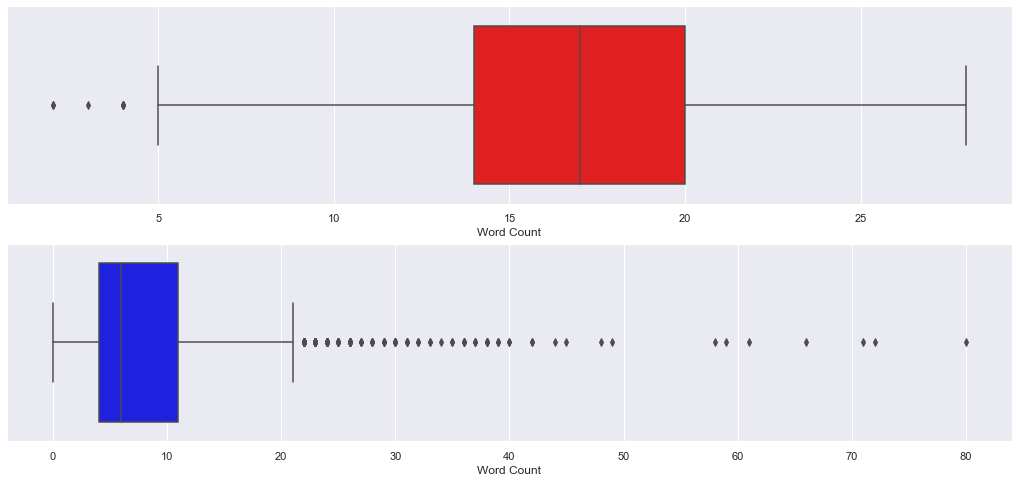

In [21]:
#visualise character count in boxplot
f,axes = plt.subplots(2,1,figsize=(18,8))
sb.boxplot(spam["Word Count"], orient = "h", color = "red", ax = axes[0])
sb.boxplot(good["Word Count"], orient = "h", color = "blue", ax = axes[1])

In [26]:
print("Average word count of spam texts: ", spam["Word Count"].mean())
print("Average word count of good texts: ", good["Word Count"].mean())

Average word count of spam texts:  16.573208722741434
Average word count of good texts:  8.24933569530558


Apparently, the average clean word count of 'spam' texts is 2 times that of 'good' texts. This feature makes a great variable in predicting whether a text is a 'spam' or 'good'. 

#### Visualising difference in character count between 'spam' and 'good' texts

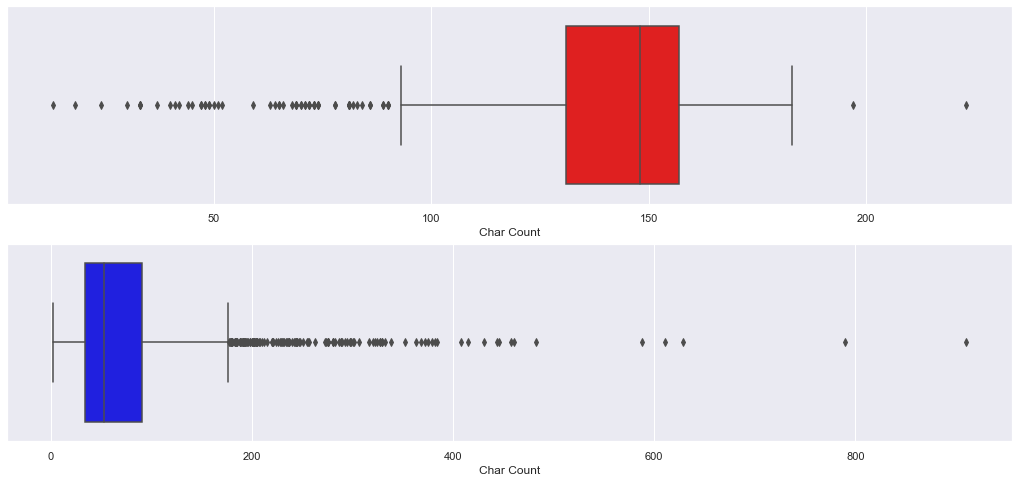

In [22]:
#visualise character count in boxplot
f,axes = plt.subplots(2,1,figsize=(18,8))
sb.boxplot(spam["Char Count"], orient = "h", color = "red", ax = axes[0])
sb.boxplot(good["Char Count"], orient = "h", color = "blue", ax = axes[1])

In [25]:
print("Average character count of spam texts: ", spam["Char Count"].mean())
print("Average character count of good texts: ", good["Char Count"].mean())

Average character count of spam texts:  137.40809968847353
Average character count of good texts:  70.87223206377325


Clearly, the average character count of 'spam' texts is almost 2 times that of 'good' texts. This feature makes a great variable in predicting whether a text is a 'spam' or 'good'. 

# Classification using ONLY tokenised words 
First, we will be using only the bag of words attained from CountVectorizer to observe the accuracy of classification using DecisionTreeClassifier and RandomForestClassifier. This will allow us to observe how well the tokenised words alone allow us to train and predict which messages are 'good' and which are 'spam'. 

In [110]:
#splitting the data into train(0.75) and test(0.25)
BOW_train, BOW_test, spamBOW_train, spamBOW_test = train_test_split(sms_bow,
                                                                   smsDD_k['label'],
                                                                   test_size = 0.25)

print("Dimension of smsBOW_train set: ", BOW_train.shape)
print("Dimension of smsBOW_test set: ", BOW_test.shape)

Dimension of smsBOW_train set:  (3868, 62)
Dimension of smsBOW_test set:  (1290, 62)


### Function to calculate True positive and negative rates, and False positive and negative rates

In [111]:
#Writing forumlas to calculate TPR, TNR, FPR, FNR
def TPR_FNR(x,y):
    res = x/(x+y)
    return res

def TNR_FPR(a,b):
    res = a/(a+b)
    return res

#### True positive:
Messages that are 'spam' correctly predicted and labelled as 'spam' by classifier.

#### True negative:
Messages that are 'good' correctly predicted and labelled as 'good' by classifier. 

#### False positive:
Messages that are 'good' wrongly predicted and labelled as 'spam' by classifier.

#### Flase negative:
Messages that are 'spam' wrongly predicted and labelled as 'good' by classifier.

## Classification with DecisionTreeClassifier 
(Using only tokenised words)

### For train set

In [112]:
#first, create a decision tree object
deciT_bow = DecisionTreeClassifier(max_depth = 8)

#next, fit the data into the object
deciT_bow.fit(BOW_train, spamBOW_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [113]:
#make predictions based on x variables (BOW_train)
spamBOW_trainP = deciT_bow.predict(BOW_train)

### Visualise the accuracy of prediction using confusion matrix

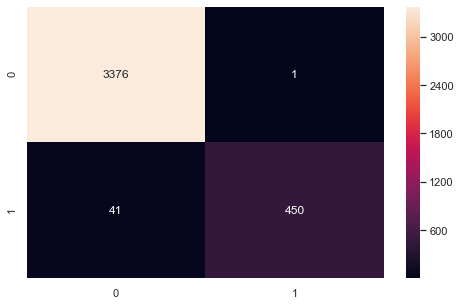

In [114]:
#plotting the confusion matrix
f,axes = plt.subplots(1,1,figsize = (8,5))
sb.heatmap(confusion_matrix(spamBOW_train, spamBOW_trainP), annot = True, fmt = '.0f', annot_kws = {"size":12})

So according to our confusion matrix, we observe that there are 3376 'good' messages correctly labelled as 'good', and 450 'spam' messages that are correctly labelled as 'spam'.

However, there are 41 'spam' messages wrongly labelled as 'good' and 1 'good' message wrongly labelled as 'spam'.

In [117]:
#calculate accuracy of prediction 
print("Value of accuracy of classification: ",deciT_bow.score(BOW_train, spamBOW_train))

#calculating TPR, TNR, FPR, FNR
TP = 450
TN = 3376
FP = 1
FN = 41
print("True positive rate:\t", round(TPR_FNR(TP,FN),3))
print("True negative rate:\t", round(TNR_FPR(TN,FP),3))
print("False positive rate:\t", round(TNR_FPR(FP,TN),3))
print("False negative rate:\t", round(TPR_FNR(FN,TP),3))

Value of accuracy of classification:  0.9891416752843847
True positive rate:	 0.916
True negative rate:	 1.0
False positive rate:	 0.0
False negative rate:	 0.084


### For test set

In [118]:
#make predictions using test set x variables
spamBOW_testP = deciT_bow.predict(BOW_test)

### Visualise the accuracy of prediction using confusion matrix

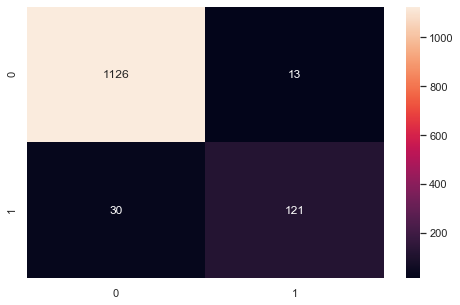

In [119]:
#plotting the confusion matrix
f,axes = plt.subplots(1,1,figsize = (8,5))
sb.heatmap(confusion_matrix(spamBOW_test, spamBOW_testP), annot = True, fmt = '.0f', annot_kws = {"size":12})

So according to our confusion matrix, we observe that there are 1126 'good' messages correctly labelled as 'good', and 121 'spam' messages that are correctly labelled as 'spam'.

However, there are 30 'spam' messages wrongly labelled as 'good' and 13 'good' messages wrongly labelled as 'spam'.

In [120]:
#calculate accuracy of prediction 
print("Value of accuracy of classification: ",deciT_bow.score(BOW_test, spamBOW_test))

#calculating TPR, TNR, FPR, FNR
TP = 121
TN = 1126
FP = 13
FN = 30
print("True positive rate:\t", round(TPR_FNR(TP,FN),3))
print("True negative rate:\t", round(TNR_FPR(TN,FP),3))
print("False positive rate:\t", round(TNR_FPR(FP,TN),3))
print("False negative rate:\t", round(TPR_FNR(FN,TP),3))

Value of accuracy of classification:  0.9666666666666667
True positive rate:	 0.801
True negative rate:	 0.989
False positive rate:	 0.011
False negative rate:	 0.199


#### Final comments on decision tree classifier using only tokenised words:
It seems that just using the stemmed, lemmatised bag of words can produce a decently accurate prediction of 96.7% for the test set. 

Let's see how the Random Forest model will perform with the same train and test set. 

## Classification with RandomForestClassifier
(Using only tokenised words )

In [121]:
#Create a random forest object
rdf_bow = RandomForestClassifier(n_estimators = 100,
                                max_depth = 4)

### For train set

In [134]:
#fit data into object
rdf_bow.fit(BOW_train, spamBOW_train)

#making predictions using x variables
rdf_spamTrainP = rdf_bow.predict(BOW_train)

### Visualise with confusion matrix

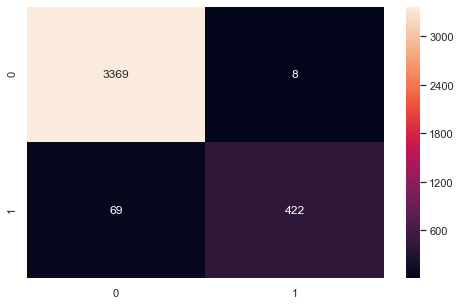

In [135]:
#plotting the confusion matrix
f,axes = plt.subplots(1,1,figsize = (8,5))
sb.heatmap(confusion_matrix(spamBOW_train, rdf_spamTrainP), annot = True, fmt = '.0f', annot_kws = {"size":12})

In [136]:
#calculate classification accuracy
print("Goodness of model:\tTrain data set:")
print("Classification accuracy\t", rdf_bow.score(BOW_train, spamBOW_train))
print()

#calculating TPR, TNR, FPR, FNR
TP = 422
TN = 3369
FP = 8
FN = 69
print("True positive rate:\t", round(TPR_FNR(TP,FN),3))
print("True negative rate:\t", round(TNR_FPR(TN,FP),3))
print("False positive rate:\t", round(TNR_FPR(FP,TN),3))
print("False negative rate:\t", round(TPR_FNR(FN,TP),3))

Goodness of model:	Train data set:
Classification accuracy	 0.9800930713547052

True positive rate:	 0.859
True negative rate:	 0.998
False positive rate:	 0.002
False negative rate:	 0.141


So according to our confusion matrix, we observe that there are 3369 'good' messages correctly labelled as 'good', and 422 'spam' messages that are correctly labelled as 'spam'.

However, there are 69 'spam' messages wrongly labelled as 'good' and 8 'spam' messages were wrongly labelled as 'good'.

### For test set

In [137]:
#making predictions for test set
rdf_spamTestP = rdf_bow.predict(BOW_test)

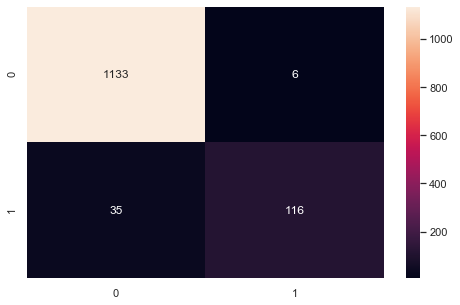

In [138]:
#plotting the confusion matrix
f,axes = plt.subplots(1,1,figsize = (8,5))
sb.heatmap(confusion_matrix(spamBOW_test, rdf_spamTestP), annot = True, fmt = '.0f', annot_kws = {"size":12})

In [139]:
#calculate classification accuracy
print("Goodness of model:\tTest data set:")
print("Classification accuracy\t", rdf_bow.score(BOW_test, spamBOW_test))
print()

#calculating TPR, TNR, FPR, FNR
TP = 116
TN = 1133
FP = 6
FN = 35
print("True positive rate:\t", round(TPR_FNR(TP,FN),3))
print("True negative rate:\t", round(TNR_FPR(TN,FP),3))
print("False positive rate:\t", round(TNR_FPR(FP,TN),3))
print("False negative rate:\t", round(TPR_FNR(FN,TP),3))

Goodness of model:	Test data set:
Classification accuracy	 0.9682170542635659

True positive rate:	 0.768
True negative rate:	 0.995
False positive rate:	 0.005
False negative rate:	 0.232


So it seems the accuracy of the random forest model for the test set is not  significantly different from the test set of the decision tree model. With an accuracy percentage of 96.8%, it outdid the Decision Tree model by a small margin of 0.1%

#### Final comments on classification using only tokenised words as variables:
A Random Forest Model is an ensemble of many Decision Tree classifiers and in simple terms, it averages the predictions returned from all the trees. Hence, there is less bias in the prediction, as compared to one Decision Tree model. 

Furthermore, the accuracy of the Random Forest model for the same test set produced a higher accuracy rate compared to a single Decision Tree model. Hence, I believe using a Random Forest Classifier to predict if a message is a 'good' or 'spam' will be the best choice with the least bias.

# Predicting 'spam' or 'good' using multiple variables

As seen above, the number of characters and clean words in 'spam' and 'good' texts vary significantly. At the same time, stemming the words can remove redundant characters like 'es', 's' and 'ing' while lemmatising the words will remove inflectional endings to return the base form of a word. This will greatly increase the frequency of specific words occuring in each text, hence proving the frequency to be a good predictor as well. 

In [94]:
#creating a dataframe of multiple variables
mult_var = pd.DataFrame(sms_bow.toarray(), columns=count.get_feature_names())
mult_var = pd.concat([mult_var, smsDD_k["Char Count"].reindex(index=mult_var.index)], axis=1, sort=False)
mult_var["Char Count"] = mult_var["Char Count"].fillna(0).astype(np.int64)
mult_var["Char Count"] = mult_var["Char Count"].astype('int64')
mult_var = pd.concat([mult_var, smsDD_k["Word Count"].reindex(index=mult_var.index)], axis=1, sort=False)
mult_var["Word Count"] = mult_var["Word Count"].fillna(0).astype(np.int64)
mult_var["Word Count"] = mult_var["Word Count"].astype('int64')
mult_var.head()

,\t,\n,,0,1,2,3,4,5,6,...,‘,’,“,…,┾,〨,鈥,Char Count,Word Count,Word Count
0,0,0,19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,111,16,16
1,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,29,6,6
2,0,0,27,5,5,5,0,1,3,0,...,0,0,0,0,0,0,0,155,23,23
3,0,0,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,49,9,9
4,0,0,12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,61,8,8


In [95]:
#calculating frequency
frq_vars = pd.DataFrame({'mean_frequency':mult_var.mean(axis=0)}, index=mult_var.columns)
frq_vars = frq_vars.sort_values(by='mean_frequency', ascending=False)
frq_vars.head()

,mean_frequency
Char Count,74.013183
,14.494572
Word Count,8.672935
Word Count,8.672935
e,6.006592


In [96]:
#consider top 50 most frequent words
frq50 = mult_var[frq_vars.index[:40]]
frq50.head()

,Char Count,,Word Count,Word Count,Word Count,Word Count,e,o,t,a,...,8,5,4,j,7,3,6,9,z,£
0,111,19,16,16,16,16,8,7,7,8,...,0,0,0,1,0,0,0,0,1,0
1,29,5,6,6,6,6,0,3,0,1,...,0,0,0,1,0,0,0,0,0,0
2,155,27,23,23,23,23,11,6,16,7,...,4,3,1,0,2,0,0,0,0,0
3,49,10,9,9,9,9,3,2,1,5,...,0,0,0,0,0,0,0,0,0,0
4,61,12,8,8,8,8,6,5,4,2,...,0,0,0,0,0,0,0,0,0,0


### Split the dataset into train and test set

In [143]:
#splitting the data into train(0.75) and test(0.25)
smsBOW_train, smsBOW_test, spam_train, spam_test = train_test_split(frq50,
                                                                   smsDD_k['label'],
                                                                   test_size = 0.25)

print("Dimension of smsBOW_train set: ", smsBOW_train.shape)
print("Dimension of smsBOW_test set: ", smsBOW_test.shape)

Dimension of smsBOW_train set:  (3868, 42)
Dimension of smsBOW_test set:  (1290, 42)


# Classifying training data set using DecisionTreeClassifier

In [144]:
#create decisiontree object
deci3 = DecisionTreeClassifier(max_depth = 8)
#fit data into deicision tree
deci3.fit(smsBOW_train, spam_train)

#train prediction of training set
spam_train_pred = deci3.predict(smsBOW_train)

### Visualising accuracy of classification using confusion_matrix

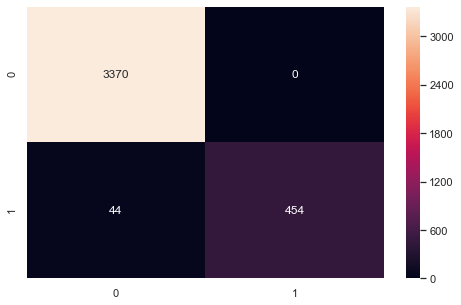

In [145]:
#plotting confusion matrix to check for true positives and negatives, and false positives and negatives
f,axes = plt.subplots(1,1, figsize = (8,5))
sb.heatmap(confusion_matrix(spam_train, spam_train_pred), annot = True, fmt = '.0f', annot_kws = {"size":12})

In [146]:
#calculate accuracy of prediction 
print("Value of accuracy of classification: ",deci3.score(smsBOW_train, spam_train))

#calculating TPR, TNR, FPR, FNR
TP = 454
TN = 3370
FP = 0
FN = 44
print("True positive rate:\t", round(TPR_FNR(TP,FN),3))
print("True negative rate:\t", round(TNR_FPR(TN,FP),3))
print("False positive rate:\t", round(TNR_FPR(FP,TN),3))
print("False negative rate:\t", round(TPR_FNR(FN,TP),3))

Value of accuracy of classification:  0.9886246122026887
True positive rate:	 0.912
True negative rate:	 1.0
False positive rate:	 0.0
False negative rate:	 0.088


### Calculating probability of classification

In [182]:
spam_pred_prob = deci3.predict_proba(smsBOW_train)
spam_trainDF = pd.DataFrame(spam_train)
prob_train = pd.DataFrame(list(spam_pred_prob[:,1]), columns = ["Proba_Spam_Train"],index=spam_train.index) #Proba_Spam refers to whether it is a spam message
acct_sms = pd.concat([spam_trainDF, prob_train], axis = 1)
acct_sms

,label,Proba_Spam_Train
3643,good,0.007521
3267,good,0.007521
385,spam,1.000000
3795,good,0.007521
8,spam,1.000000
...,...,...
1825,good,0.007521
1243,good,0.007521
4513,good,0.007521
5156,good,0.007521


## Use DecisionTreeClassifier for test data set

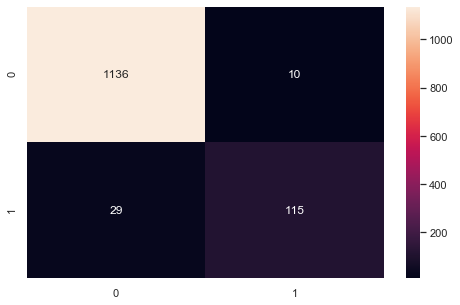

In [183]:
#predict whether a text is a spam or not
spam_test_pred = deci3.predict(smsBOW_test)

#visualise with a confusion_matrix
f,axes = plt.subplots(1,1,figsize = (8,5))
sb.heatmap(confusion_matrix(spam_test, spam_test_pred), annot = True, annot_kws={"size":12}, fmt='.0f')

In [184]:
#calculate accuracy of classification
print("Value of accuracy of classification: ", deci3.score(smsBOW_test, spam_test))
print()

#calculating TPR, TNR, FPR, FNR
TP = 115
TN = 1136
FP = 10
FN = 29
print("True positive rate:\t", round(TPR_FNR(TP,FN),3))
print("True negative rate:\t", round(TNR_FPR(TN,FP),3))
print("False positive rate:\t", round(TNR_FPR(FP,TN),3))
print("False negative rate:\t", round(TPR_FNR(FN,TP),3))

Value of accuracy of classification:  0.9697674418604652

True positive rate:	 0.799
True negative rate:	 0.991
False positive rate:	 0.009
False negative rate:	 0.201


In [218]:
#calculate probability
spam_pred_prob2 = deci3.predict_proba(smsBOW_test)
spam_testDF = pd.DataFrame(spam_test)
prob_test = pd.DataFrame(list(spam_pred_prob2[:,1]), columns = ["Proba_Spam_Test"],index=spam_test.index) #Proba_Spam refers to whether it is a spam message
acct_sms2 = pd.concat([spam_testDF, prob_test], axis=1)
acct_sms2

,label,Proba_Spam_Test
3697,good,0.007521
3214,good,0.007521
671,good,0.007521
4243,spam,1.000000
3063,good,0.007521
...,...,...
666,good,0.007521
2795,good,0.007521
4907,good,0.007521
4857,good,0.007521


In [223]:
#concatenating the columns of texts, labels, Proba_Spam_Train and Proba_Spam_Test
Final_op = pd.concat([smsDD_k, prob_train, prob_test], axis = 1)
Final_op

,text,label,Char Count,Word Count,Word Count,Proba_Spam_Train,Proba_Spam_Test
0,"Go until jurong point, crazy.. Available only ...",good,111,16,16,0.007521,NaN
1,Ok lar... Joking wif u oni...,good,29,6,6,NaN,0.007521
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,155,23,23,1.000000,NaN
3,U dun say so early hor... U c already then say...,good,49,9,9,0.007521,NaN
4,"Nah I don't think he goes to usf, he lives aro...",good,61,8,8,0.007521,NaN
...,...,...,...,...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam,160,20,20,NaN,1.000000
5568,Will ü b going to esplanade fr home?,good,36,6,6,0.007521,NaN
5569,"Pity, * was in mood for that. So...any other s...",good,57,4,4,0.007521,NaN
5570,The guy did some bitching but I acted like i'd...,good,125,14,14,0.007521,NaN


This does not look neat so let's combine the Proba_Spam_Train and Proba_Spam_Test into a single column.

In [224]:
#First, replace the NaN with 0.000 float values
Final_op["Proba_Spam_Train"] = Final_op["Proba_Spam_Train"].fillna(0).astype('float64')
Final_op["Proba_Spam_Test"] = Final_op["Proba_Spam_Test"].fillna(0).astype('float64')

#Create a temporary dataframe that holds the sum of the float values
a = Final_op["Proba_Spam_Train"].to_frame() #Series need to be converted to a DataFrame
b = Final_op["Proba_Spam_Test"].to_frame().reindex(index=a.index)
c = pd.concat([a,b], axis = 1)
c['Proba_Spam'] = c.sum(axis=1) 
del c["Proba_Spam_Train"]
del c["Proba_Spam_Test"]

In [221]:
#drop the old proba columns
del Final_op["Proba_Spam_Train"]
del Final_op["Proba_Spam_Test"]

#concat the new column to the final dataframe
Final_op = pd.concat([Final_op, c], axis=1)
Final_op.head(10)

,text,label,Char Count,Word Count,Word Count,Proba_Spam
0,"Go until jurong point, crazy.. Available only ...",good,111,16,16,0.007521
1,Ok lar... Joking wif u oni...,good,29,6,6,0.007521
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,155,23,23,1.000000
3,U dun say so early hor... U c already then say...,good,49,9,9,0.007521
4,"Nah I don't think he goes to usf, he lives aro...",good,61,8,8,0.007521
5,FreeMsg Hey there darling it's been 3 week's n...,spam,147,19,19,1.000000
6,Even my brother is not like to speak with me. ...,good,77,8,8,0.007521
7,As per your request 'Melle Melle (Oru Minnamin...,good,160,16,16,0.071429
8,WINNER!! As a valued network customer you have...,spam,157,18,18,1.000000
9,Had your mobile 11 months or more? U R entitle...,spam,154,18,18,1.000000


There we have it, by using the `.predict_proba()` and summing the values of the former columns 'Proba_Spam_Train' and 'Proba_Spam_Test', I was able to create a neat table showing the probability of each text being a 'spam' as predicted by the Decision Tree Model. 

# Using Random Forest Classifier for classification of 'good' and 'spam' texts

### Training the train set

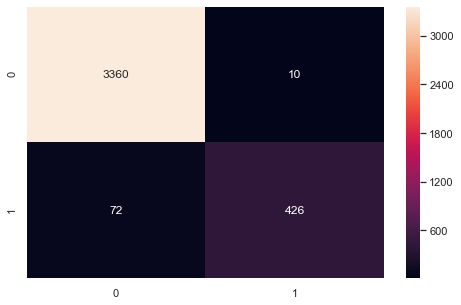

In [153]:
#create a random forest classifier object for train set
rdf_train = RandomForestClassifier(n_estimators = 100,
                                  max_depth = 4)

#fit data into random forest object
rdf_train.fit(smsBOW_train, spam_train)

#predict whether the response value is a 'spam' or 'good'
spam_train_pred = rdf_train.predict(smsBOW_train)

#visualise with confusion_matrix
f,axes = plt.subplots(1,1,figsize=(8,5))
sb.heatmap(confusion_matrix(spam_train, spam_train_pred), annot = True, annot_kws = {"size":12}, fmt = '.0f')

In [154]:
#calculate classification accuracy
print("Goodness of model:\tTrain data set:")
print("Classification accuracy\t", rdf_train.score(smsBOW_train, spam_train))
print()

#calculating TPR, TNR, FPR, FNR
TP = 426
TN = 3360
FP = 10
FN = 72
print("True positive rate:\t", round(TPR_FNR(TP,FN),3))
print("True negative rate:\t", round(TNR_FPR(TN,FP),3))
print("False positive rate:\t", round(TNR_FPR(FP,TN),3))
print("False negative rate:\t", round(TPR_FNR(FN,TP),3))

Goodness of model:	Train data set:
Classification accuracy	 0.9788004136504653

True positive rate:	 0.855
True negative rate:	 0.997
False positive rate:	 0.003
False negative rate:	 0.145


### Testing the test set

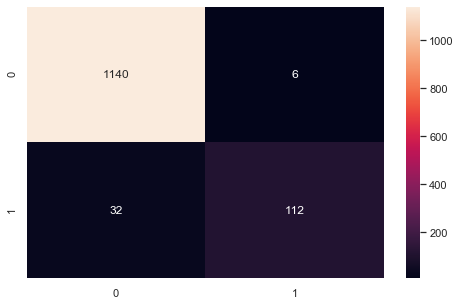

In [155]:
#predict whether the response value is a 'spam' or 'good'
spam_test_pred = rdf_train.predict(smsBOW_test)

#visualise with confusion_matrix
f,axes = plt.subplots(1,1,figsize=(8,5))
sb.heatmap(confusion_matrix(spam_test, spam_test_pred), annot = True, annot_kws = {"size":12}, fmt = '.0f')

In [156]:
#calculate classification accuracy
print("Goodness of model:\tTest data set:")
print("Classification accuracy\t", rdf_train.score(smsBOW_test, spam_test))
print()

#calculating TPR, TNR, FPR, FNR
TP = 112
TN = 1140
FP = 6
FN = 32
print("True positive rate:\t", round(TPR_FNR(TP,FN),3))
print("True negative rate:\t", round(TNR_FPR(TN,FP),3))
print("False positive rate:\t", round(TNR_FPR(FP,TN),3))
print("False negative rate:\t", round(TPR_FNR(FN,TP),3))

Goodness of model:	Test data set:
Classification accuracy	 0.9705426356589147

True positive rate:	 0.778
True negative rate:	 0.995
False positive rate:	 0.005
False negative rate:	 0.222


## Conclusion:
In terms of Decision Tree classification, the accuracy of the model using only tokenised words as variables was 96.7% while that of the model using multiple variables was 97.0%, indicating a mere 0.3% increase in accuracy rate. This illustrates that the most significant variable in predicting whether a text was 'spam' or 'good' was the collection of stemmed, lemmatised and tokenised bag of words. Variables such as frequency of each word, total number of characters and words in each text did not play as huge a role in enhancing the accuracy of the prediction. 

In terms of Random Forest classification, similarly the accuracy of the model using only tokenised words as variables was 96.8% while that of the model using multiple variables was 97.1%, indicating only a 0.3% improvement in accuracy rate. This again emphasises the major role the collection of stemmed, lemmatised and tokenised bag of words play in making accurate predictions of a message being a 'spam' or 'good'. 

On the whole, Random Forest performed slightly better than Decision Tree and together with the lower level of bias in the Random Forest model, it would be best to employ Random Forest Classification when predicting future 'spam' messages from the 'good' ones. 

# Reference(s):
For CountVectorizer and tokenising words: 
https://www.youtube.com/watch?v=cNLPt02RwF0&t=729s



For renaming columns: https://stackoverflow.com/questions/11346283/renaming-columns-in-pandas

For Lemmatisation: https://stackoverflow.com/questions/47557563/lemmatization-of-all-pandas-cells

For Stemming: https://stackoverflow.com/questions/12974045/porterstemmer-doesnt-seem-to-work

For deleting columns: https://stackoverflow.com/questions/13411544/delete-column-from-pandas-dataframe

For adding values between 2 dataframes:
https://stackoverflow.com/questions/25748683/pandas-sum-dataframe-rows-for-given-columns

For conversion of Series to DataFrame: 
https://www.geeksforgeeks.org/python-pandas-series-to_frame/

Decision Tree and Random Forest:
https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76